# Small CNN for traffic sign recognition as template for  assignment
## Christian Igel, 2020

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import pathlib
import os

print("TensorFlow version:", tf.__version__)

AUTOTUNE = tf.data.experimental.AUTOTUNE

TensorFlow version: 2.2.0-rc4


Download the data:

In [3]:
data_root="."
tf.keras.utils.get_file("GTSRB.zip",
                        "https://sid.erda.dk/share_redirect/EB0rrpZwuI",
                        cache_dir=data_root,
                        extract=True)


290897920/290897892 [==============================] - 30s 0us/step


'./datasets/GTSRB.zip'

The images are stored in subdirectories. The names of the subdirectories encode the class labels. 

In [4]:
# Determine the number of training and test images
n_train = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/train/*/*")))
n_test = len(list(pathlib.Path(data_root).glob("datasets/GTSRB/test/*/*")))

print("Number of training images:", n_train)
print("Number of test images:" ,n_test)

Number of training images: 39209
Number of test images: 12630


Some basic constants: 

In [0]:
no_classes = 43  # There are 43 different signs
no_channels = 3  # We are dealing with color images

# All images are initially resized to img_height x img_width
img_height  = 32  
img_width   = 32
# During training and testing the  images are cropped to img_height_crop x img_width_crop
img_height_crop = 28  
img_width_crop  = 28

batch_size = 128
steps_per_epoch = n_train // batch_size  # How many batches are there in each epoch?

Helper function for extracting the label information from the paths to the images and loading and preprocessing the images:

In [0]:
# Extract the label from the file path
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return tf.strings.to_number(parts[-2], tf.int32)

# Load image, convert it to floats, and resize it
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=no_channels)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, [img_width, img_height])

# Given the path and filename of an image, create the label and the input image
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Create data sets based on the files:

In [0]:
# Tell dataset the lists of files containing the trainig and test images, respectively
list_ds_train = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/train/*/*")
list_ds_test  = tf.data.Dataset.list_files(data_root + "/datasets/GTSRB/test/*/*", shuffle=False)  # Fixed order for test time augemantation 

# Tell dataset how to extract images and labels
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

Functions for data preprocessing/augmentation:

In [0]:
# Used for training data augmentation
def augment(image, label):
    image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
    image = tf.case([(tf.equal(label, 11), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 12), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 13), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 17), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 18), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 26), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 30), lambda: tf.image.random_flip_left_right(image)),
                     (tf.equal(label, 35), lambda: tf.image.random_flip_left_right(image))], default = lambda: image)
    image = tf.image.random_brightness(image, max_delta=0.1) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label

# Used for testing/evaluation
def crop_center(image, label):
  image = tf.image.resize_with_crop_or_pad(image, img_height_crop, img_width_crop)
  return image, label

# Could be used for test time augementation
def crop_random(image, label):
  image = tf.image.random_crop(image, [img_height_crop, img_width_crop, no_channels])
  return image, label


We prepare the data for training and testing differently. For example, for training we use data augmentation.

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # `.cache(filename)` is used to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):  # Is the chache argument a string?
      ds = ds.cache(cache)  # If yes, we cache to a file
    else:
      ds = ds.cache()  
  # We shuffle the data after the caching
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
  # Repeat forever
  ds = ds.repeat()
  # Do data augmentation
  ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_evaluation(ds, shuffle_buffer_size=1000):
  # For normal evaluation, we look at the center of the image
  ds = ds.map(crop_center, num_parallel_calls=AUTOTUNE)
  # Partition in batches
  ds = ds.batch(batch_size)
  # Fetch batches in the background while the model training
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_augmented_evaluation(ds):
  ds = ds.map(crop_random, num_parallel_calls=AUTOTUNE)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

Let's have a look at a random batch of images:

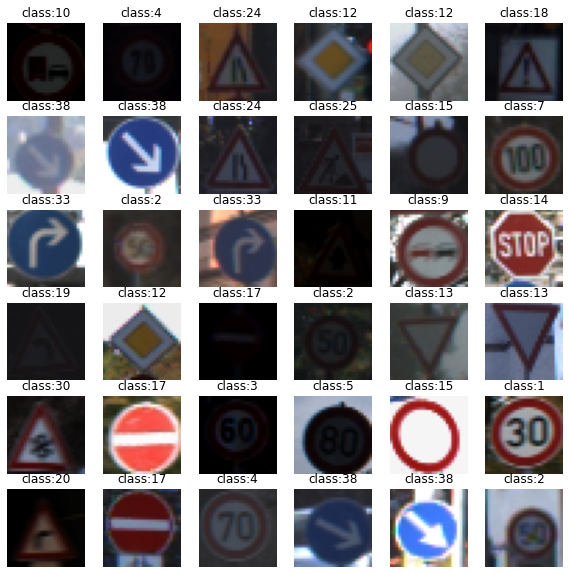

In [10]:
# Helper function for displaying images
def show_batch(image_batch, label_batch, nrows=6, ncols=6):
  plt.figure(figsize=(10,10))
  for n in range(nrows*ncols):
      ax = plt.subplot(nrows, ncols, n+1)
      if no_channels == 3:
        plt.imshow(image_batch[n])
      else:
        plt.imshow(image_batch[n].reshape([img_height_crop, img_width_crop]))
      plt.title('class:' + str(label_batch[n]))
      plt.axis('off')
# Make training dataset to retrieve some images
train_ds = prepare_for_training(labeled_ds_train)

# Get a batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Visualize images and labels
show_batch(image_batch.numpy(), label_batch.numpy())

Define a neural network model:

In [13]:
sd_init = 0.01  # Standard deviation and offset for initializing bias parameters in hidden layers

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation=None,  
                           input_shape=(img_width_crop, img_height_crop, no_channels),
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation=None, 
                           bias_initializer=tf.initializers.TruncatedNormal(mean=sd_init, stddev=sd_init)),
    tf.keras.layers.ELU(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(no_classes, activation='softmax')])
 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
elu_2 (ELU)                  (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
elu_3 (ELU)                  (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

Define optimizer and compile the model:

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Do the learning:

In [17]:
history = model.fit(train_ds, epochs=500, steps_per_epoch=steps_per_epoch)

Epoch 1/500
306/306 [==============================] - 24s 79ms/step - loss: 3.5849 - accuracy: 0.0721
Epoch 2/500
306/306 [==============================] - 8s 25ms/step - loss: 3.3896 - accuracy: 0.1475
Epoch 3/500
306/306 [==============================] - 7s 24ms/step - loss: 3.0997 - accuracy: 0.2429
Epoch 4/500
306/306 [==============================] - 7s 24ms/step - loss: 2.6370 - accuracy: 0.3245
Epoch 5/500
306/306 [==============================] - 7s 24ms/step - loss: 2.2033 - accuracy: 0.4059
Epoch 6/500
306/306 [==============================] - 7s 24ms/step - loss: 1.8602 - accuracy: 0.4887
Epoch 7/500
306/306 [==============================] - 8s 25ms/step - loss: 1.6081 - accuracy: 0.5582
Epoch 8/500
306/306 [==============================] - 8s 25ms/step - loss: 1.4113 - accuracy: 0.6132
Epoch 9/500
306/306 [==============================] - 8s 25ms/step - loss: 1.2688 - accuracy: 0.6568
Epoch 10/500
306/306 [==============================] - 8s 25ms/step - loss: 1.14

Let's evaluate the model:

In [18]:
eval_train_ds = prepare_for_evaluation(labeled_ds_train)
eval_test_ds = prepare_for_evaluation(labeled_ds_test)
results = model.evaluate(eval_train_ds)
print('Train loss, train acc:', results)
results = model.evaluate(eval_test_ds)
print('Test loss, test acc:', results)

307/307 [==============================] - 20s 65ms/step - loss: 0.0037 - accuracy: 0.9993
Train loss, train acc: [0.003664036514237523, 0.999285876750946]
99/99 [==============================] - 6s 63ms/step - loss: 0.5760 - accuracy: 0.9405
Test loss, test acc: [0.5759748220443726, 0.9404592514038086]


There are lot of ways to improve the model above. According to Stallkamp et al. (2012), an ensemble of CNNs can reach 99.46%. Good human performance is 
99.22%.